In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beckoliver","key":"848de19a3d6d1fc6166df8bd32d747f1"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d obulisainaren/multi-cancer

100% 8.61G/8.62G [01:34<00:00, 45.6MB/s]
100% 8.62G/8.62G [01:34<00:00, 98.2MB/s]


In [5]:
!unzip '/content/multi-cancer.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0002.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0003.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0004.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0005.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0006.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0007.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0008.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0009.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0010.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0011.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0012.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0013.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0014.jpg  
  inflating: Multi Cancer/Oral Cancer/oral_scc/oral_scc_0015.jpg  
  inflating

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

In [8]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [9]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

In [10]:
class ImageDataProcessor:
    def __init__(self, path):
        self.base_path = path
        self.train_datagen = ImageDataGenerator(validation_split=0.3)
        self.no_of_classes = 0
        self.class_names = []

    def initiate_generator(self):
        self._generate_dataset()
        self._generate_data_generators()
        self._plot_sample_images()
        self._print_image_shape()
        return self.class_names, self.no_of_classes, self.train_generator, self.validation_generator

    def _generate_dataset(self):
        print("\nTotal : ", end=" ")
        self.train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=self.base_path)
        self.class_names = self.train_dataset.class_names
        self.no_of_classes = len(self.class_names)

    def _generate_data_generators(self):
        self.train_generator = self._create_generator(subset='training')
        self.validation_generator = self._create_generator(subset='validation', shuffle=False)
        print("\nNo of Classes : ", self.no_of_classes)
        print("Classes : ", self.class_names)

    def _create_generator(self, subset, shuffle=True):
        print(f"\nFor {subset.capitalize()} : ", end=" ")
        return self.train_datagen.flow_from_directory(
            self.base_path,
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical',
            subset=subset,
            shuffle=shuffle
        )

    def _plot_sample_images(self):
        plt.figure(figsize=(10, 10))
        for images, labels in self.train_dataset.take(1):
            for i in range(self.no_of_classes):
                ax = plt.subplot(4, 4, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(self.class_names[labels[i]])
                plt.axis("off")

    def _print_image_shape(self):
        for image_batch, _ in self.train_dataset.take(1):
            print("Image Shape : ", image_batch.shape)
            break

In [11]:
class DataNormalizer:
    def __init__(self, train_generator, val_generator):
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.normalized_ds = None
        self.AUTOTUNE = tf.data.AUTOTUNE

    def initiate_normalize(self):
        self._prepare_datasets()
        self._normalize_datasets()
        self._display_sample()

    def _prepare_datasets(self):
        self.train_ds = self.train_generator.cache().shuffle(1000).prefetch(buffer_size=self.AUTOTUNE)
        self.val_ds = self.val_generator.cache().prefetch(buffer_size=self.AUTOTUNE)

    def _normalize_datasets(self):
        normalization_layer = layers.Rescaling(1./255)
        self.normalized_ds = self.train_ds.map(lambda x, y: (normalization_layer(x), y))

    def _display_sample(self):
        image_batch, labels_batch = next(iter(self.normalized_ds))
        first_image = image_batch[0]
        print(f"Min pixel value: {np.min(first_image)}, Max pixel value: {np.max(first_image)}")


In [12]:
class ImageClassifier:
    def __init__(self, no_of_classes, image_size, class_name, train_generator, validation_generator):
        self.no_of_classes = no_of_classes
        self.image_size = image_size
        self.class_name = class_name
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.model = None
        self.annealer = None
        self.checkpoint = None

    def initiate_model(self):
        model_input = tf.keras.applications.VGG16(
            input_shape=self.image_size + [3],
            include_top=False,
            weights="imagenet"
        )

        for layer in model_input.layers:
            layer.trainable = False

        x = Flatten()(model_input.output)
        prediction = Dense(self.no_of_classes, activation='softmax')(x)

        self.model = Model(inputs=model_input.input, outputs=prediction)
        return self.model

    def model_summary(self):
        if self.model is not None:
            self.model.summary()
        else:
            print("Model has not been initialized yet.")


    def initiate_params(self, lr):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        self.annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        self.checkpoint = ModelCheckpoint(self.class_name + 'VGG16.h5', verbose=1, save_best_only=True)

        return self.model, self.annealer, self.checkpoint

    def model_fit(self, epochs=20, batch_size=256):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[self.annealer, self.checkpoint],
            steps_per_epoch=len(self.train_generator),
            validation_steps=len(self.validation_generator)
        )
        return history

    def eval_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        evl = self.model.evaluate(self.validation_generator)
        acc = evl[1] * 100
        msg = f'Accuracy on the Test Set = {acc:5.2f} %'
        print(msg)

    def save_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        file_path = self.class_name + " - VGG16.h5"
        self.model.save(file_path)
        print(f"Model saved to {file_path}!")



In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

class PlotMetrics:

    def plot_output(self, history, epochs):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(epochs)

        sns.set(style='whitegrid')
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        sns.lineplot(epochs_range, acc, label='Training Accuracy')
        sns.lineplot(epochs_range, val_acc, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        sns.lineplot(epochs_range, loss, label='Training Loss')
        sns.lineplot(epochs_range, val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

        plt.tight_layout()
        plt.show()
        plt.savefig(self.class_name + '_performance_graph.png')

    def plot_confusion_matrix(self, cm, target_names, title='Confusion matrix', normalize=True):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', cbar=False,
                    xticklabels=target_names, yticklabels=target_names)
        plt.title(title)
        plt.ylabel('True label')
        plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}')
        plt.tight_layout()
        plt.show()
        plt.savefig(title + '.png')

    def call_plot(self):
        y_true = self.validation_generator.classes
        y_pred = self.model.predict(self.validation_generator)
        y_pred = np.argmax(y_pred, axis=1)
        conf_mat = confusion_matrix(y_true, y_pred)

        self.plot_confusion_matrix(cm=conf_mat,
                                   normalize=False,
                                   target_names=self.class_names,
                                   title=self.class_name + " Confusion Matrix")


In [14]:
data_dir = '/content/Multi Cancer'
cancer_classes = os.listdir(data_dir)
print(cancer_classes)

['Lung and Colon Cancer', 'Breast Cancer', 'Cervical Cancer', 'Oral Cancer', 'ALL', 'Brain Cancer', 'Lymphoma', 'Kidney Cancer']


#Cervical Caner


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Validation :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
58889256/58889256 [==============================] - 0s 0us/step


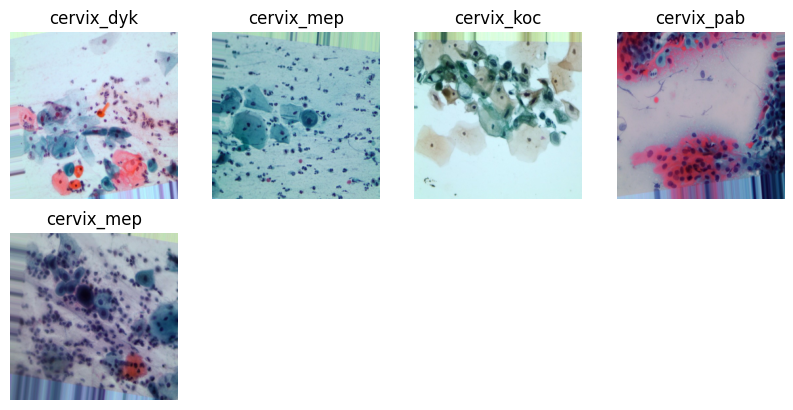

In [15]:
target_class = 'Cervical Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
cervical_model = classifierObj.initiate_model()

In [17]:
cervical_model, cervical_annealer, cervical_model_checkpoints = classifierObj.initiate_params(lr=0.001)
cervical_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9957
Epoch 1: val_loss improved from inf to 0.57126, saving model to Cervical CancerVGG16.h5
547/547 [==============================] - 116s 208ms/step - loss: 0.2118 - accuracy: 0.9957 - val_loss: 0.5713 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9958
Epoch 2: val_loss improved from 0.57126 to 0.55501, saving model to Cervical CancerVGG16.h5
547/547 [==============================] - 106s 194ms/step - loss: 0.2151 - accuracy: 0.9958 - val_loss: 0.5550 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9961
Epoch 3: val_loss did not improve from 0.55501
547/547 [==============================] - 115s 211ms/step - loss: 0.1697 - accuracy: 0.9961 - val_loss: 0.6796 - val_accuracy: 0.9903 - lr: 0.0010
Epoch 4/10
547/547 [=====================

#Brain Cancer


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Validation :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)


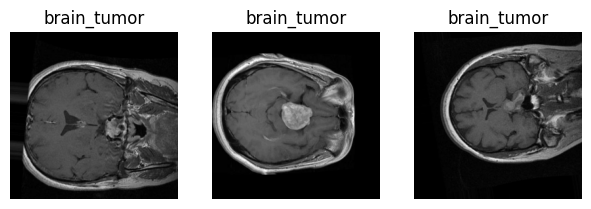

In [18]:
target_class = 'Brain Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
brain_model = classifierObj.initiate_model()

In [19]:
brain_model, brain_annealer, brain_model_checkpoints = classifierObj.initiate_params(lr=0.001)
brain_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 2.3445 - accuracy: 0.8913
Epoch 1: val_loss improved from inf to 1.98290, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 72s 215ms/step - loss: 2.3445 - accuracy: 0.8913 - val_loss: 1.9829 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.9596
Epoch 2: val_loss improved from 1.98290 to 1.31254, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 63s 192ms/step - loss: 0.7497 - accuracy: 0.9596 - val_loss: 1.3125 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.9754
Epoch 3: val_loss improved from 1.31254 to 0.81697, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 64s 193ms/step - loss: 0.4574 - accuracy: 0.9754 - val_loss: 0.8170 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 4/

#Kidney Cancer


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Validation :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)


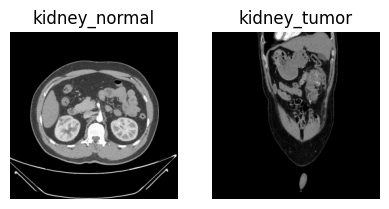

In [20]:
target_class = 'Kidney Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
kidney_model = classifierObj.initiate_model()

In [21]:
kidney_model, kidney_annealer, kidney_model_checkpoints = classifierObj.initiate_params(lr=0.001)
kidney_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.9819
Epoch 1: val_loss improved from inf to 3.95407, saving model to Kidney CancerVGG16.h5
219/219 [==============================] - 49s 216ms/step - loss: 0.3554 - accuracy: 0.9819 - val_loss: 3.9541 - val_accuracy: 0.9003 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9974
Epoch 2: val_loss did not improve from 3.95407
219/219 [==============================] - 41s 188ms/step - loss: 0.0311 - accuracy: 0.9974 - val_loss: 4.9455 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9951
Epoch 3: val_loss improved from 3.95407 to 3.86308, saving model to Kidney CancerVGG16.h5
219/219 [==============================] - 41s 188ms/step - loss: 0.1215 - accuracy: 0.9951 - val_loss: 3.8631 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 4/10
219/219 [============================

#Breast Cancer


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Validation :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)


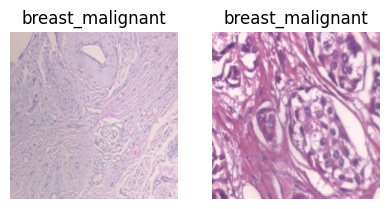

In [22]:
target_class = 'Breast Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
breast_model = classifierObj.initiate_model()

In [23]:
breast_model, breast_annealer, breast_model_checkpoints = classifierObj.initiate_params(lr=0.001)
breast_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.8335 - accuracy: 0.9659
Epoch 1: val_loss improved from inf to 0.49302, saving model to Breast CancerVGG16.h5
219/219 [==============================] - 88s 396ms/step - loss: 0.8335 - accuracy: 0.9659 - val_loss: 0.4930 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.9896
Epoch 2: val_loss improved from 0.49302 to 0.46067, saving model to Breast CancerVGG16.h5
219/219 [==============================] - 71s 324ms/step - loss: 0.2692 - accuracy: 0.9896 - val_loss: 0.4607 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9950
Epoch 3: val_loss did not improve from 0.46067
219/219 [==============================] - 88s 404ms/step - loss: 0.0907 - accuracy: 0.9950 - val_loss: 0.6571 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 4/10
219/219 [============================

#Lung and Colon Cancer


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Validation :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)


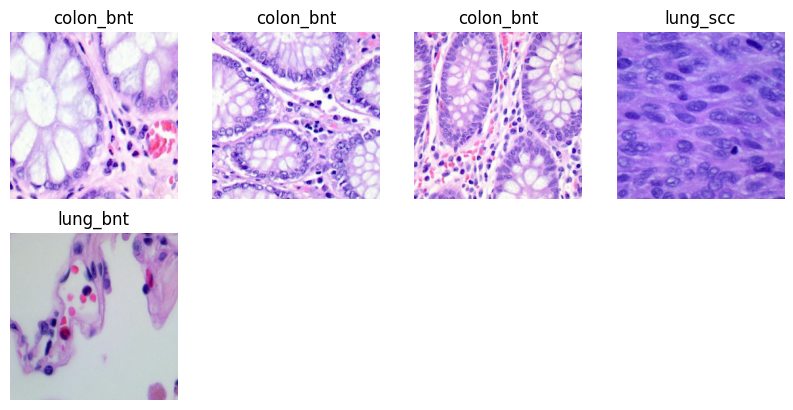

In [24]:
target_class = 'Lung and Colon Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
lung_model = classifierObj.initiate_model()

In [ ]:
lung_model, lung_annealer, lung_model_checkpoints = classifierObj.initiate_params(lr=0.001)
lung_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 1.3978 - accuracy: 0.9395
Epoch 1: val_loss improved from inf to 0.75979, saving model to Lung and Colon CancerVGG16.h5
547/547 [==============================] - 114s 207ms/step - loss: 1.3978 - accuracy: 0.9395 - val_loss: 0.7598 - val_accuracy: 0.9673 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.9802
Epoch 2: val_loss did not improve from 0.75979
547/547 [==============================] - 107s 195ms/step - loss: 0.5190 - accuracy: 0.9802 - val_loss: 0.7681 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9887
Epoch 3: val_loss did not improve from 0.75979
547/547 [==============================] - 107s 195ms/step - loss: 0.2412 - accuracy: 0.9887 - val_loss: 0.9401 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 4/10
547/547 [==============================] - ETA: 0s - loss: 0.2446 - a

#Lymphoma

In [ ]:
target_class = 'Lymphoma'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
lymph_model = classifierObj.initiate_model()

In [ ]:
lymph_model, lymph_annealer, lymph_model_checkpoints = classifierObj.initiate_params(lr=0.001)
lymph_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

#Oral Cancer

In [ ]:
target_class = 'Oral Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
oral_model = classifierObj.initiate_model()

In [ ]:
oral_model, oral_annealer, oral_model_checkpoints = classifierObj.initiate_params(lr=0.001)
oral_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

#EfficientNet Model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

class EfficientNetClassifier:
    def __init__(self, no_of_classes, image_size, class_name, train_generator, validation_generator):
        self.no_of_classes = no_of_classes
        self.image_size = image_size
        self.class_name = class_name
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.model = None
        self.annealer = None
        self.checkpoint = None

    def initiate_model(self):
        model_input = EfficientNetB0(
            input_shape=self.image_size + [3],
            include_top=False,
            weights="imagenet"
        )

        for layer in model_input.layers:
            layer.trainable = False

        x = Flatten()(model_input.output)
        prediction = Dense(self.no_of_classes, activation='relu')(x)

        # Create the model object
        self.model = Model(inputs=model_input.input, outputs=prediction)
        return self.model

    def model_summary(self):
        if self.model is not None:
            self.model.summary()
        else:
            print("Model has not been initialized yet.")

    def initiate_params(self, lr):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        self.annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        self.checkpoint = ModelCheckpoint(self.class_name + 'EfficientNetB0.h5', verbose=1, save_best_only=True)

        return self.model, self.annealer, self.checkpoint

    def model_fit(self, epochs=20, batch_size=256):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[self.annealer, self.checkpoint],
            steps_per_epoch=len(self.train_generator),
            validation_steps=len(self.validation_generator)
        )
        return history

    def eval_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        # Evaluate the model
        evl = self.model.evaluate(self.validation_generator)
        acc = evl[1] * 100
        msg = f'Accuracy on the Test Set = {acc:5.2f} %'
        print(msg)

    def save_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        file_path = self.class_name + " - EfficientNetB0.h5"
        self.model.save(file_path)
        print(f"Model saved to {file_path}!")


#Cervical Cancer

In [ ]:
target_class = 'Cervical Cancer'
target_data_path = f'/content/Multi Cancer/{target_class}'

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObjB0 = EfficientNetClassifier(no_of_classes=class_count, class_name=target_class, image_size=[224, 224], train_generator=train_gen, validation_generator=valid_gen)
cervical_modelB0 = classifierObjB0.initiate_model()

In [ ]:
cervical_modelB0, cervical_annealerB0, cervical_model_checkpointsB0 = classifierObjB0.initiate_params(lr=1)
cervical_model_history_B0 = classifierObjB0.model_fit(epochs=10, batch_size=256)

#The Accuracy of the EfficientNet model falls far behind VGG Model. Therefore VGG model is finalized for predictions

In [ ]:
import os
os.listdir('/content/')